<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/foray%20into%20weird%20chi2toz%20metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])/windowsize
  return smooth_arr

def get_smoothed_arrs(arrs, windowsize):
  arr_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  smooth_arr = (arr_cumsum[:,windowsize:] - arr_cumsum[:,:-windowsize])/windowsize
  return smooth_arr

def ljungbox_lag1(values):
  values = values - np.mean(values) #demean
  var = np.sum(values*values)/len(values)
  acf = np.sum(values[1:]*values[:-1])/(len(values)*var)
  sacf2 = acf**2/(len(values) - 1)
  qljungbox = len(values)*(len(values)+2)*sacf2

  return qljungbox, scipy.stats.chi2.sf(qljungbox, 1)

def ljungboxq_lag1_manyvals(values_2darr):
  values_2darr = values_2darr - np.mean(values_2darr, axis=1)[:,None]
  vars = np.sum(values_2darr*values_2darr, axis=1)/values_2darr.shape[1]
  acfs = np.sum(values_2darr[:,1:]*values_2darr[:,:-1], axis=1)/(values_2darr.shape[1]*vars)
  sacfs2 = np.square(acfs)/(values_2darr.shape[1] - 1)
  qsljungbox = values_2darr.shape[1]*(values_2darr.shape[1]+2)*sacfs2

  return qsljungbox

def perform_powerspectrum_analysis(values, num_permutations):

  toreturndict = {}

  ljungbox_q, ljungbox_p = ljungbox_lag1(values)
  toreturndict['pval_ljundbox'] = ljungbox_p

  freqs = np.fft.rfftfreq(len(values), 1)
  rps = get_relative_power_spectrum(values)

  #permute the test data sequence num_permutations times to get an empirical null
  rng = np.random.RandomState(1234)
  rps_permute_2darr = np.array([get_relative_power_spectrum(rng.permutation(values))
                                  for i in range(num_permutations)])

  uniform_expectation = 1.0/len(rps)

  expected_freq = np.sum(freqs*rps)
  expected_freq_permute_arr = np.sum(freqs[None,:]*rps_permute_2darr, axis=1)
  pval_ef = np.sum(expected_freq_permute_arr >= expected_freq)/len(expected_freq_permute_arr)

  maxd = np.max(np.abs(np.cumsum(rps - uniform_expectation)))
  maxd_permute_arr = np.max(np.abs(np.cumsum(rps_permute_2darr - uniform_expectation, axis=1)), axis=1);
  pval_maxd = np.sum(maxd_permute_arr >= maxd)/len(maxd_permute_arr)

  smooth_pvals = {}
  peak_freqs = {} #just for information purposes
  freq_stepsize = freqs[1]
  smoothfreqwindows = [('p00625', 0.00625),
                       ('p0075', 0.0075),
                       ('p01', 0.01),
                       ('p0125', 0.0125),
                       ('p015', 0.015),
                       ('p02', 0.02),
                       ('p025', 0.025),
                       ('p05', 0.05)]
  for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
    windowsize = int(smoothfreqwindow/freq_stepsize)
    smooth_rps = get_smoothed_arr(rps, windowsize)
    smooth_xaxis = get_smoothed_arr(freqs, windowsize)
    argmax_smooth_rps = np.argmax(smooth_rps)
    max_smooth_rps = smooth_rps[argmax_smooth_rps]
    peak_freq = smooth_xaxis[argmax_smooth_rps]
    max_smooth_rps_permutetest_2darr = np.max(
      get_smoothed_arrs(rps_permute_2darr, windowsize), axis=1)
    pval_smooth = (np.sum(max_smooth_rps_permutetest_2darr
                   >= max_smooth_rps)/len(max_smooth_rps_permutetest_2darr))
    smooth_pvals[smoothfreqwindow] = pval_smooth
    peak_freqs[smoothfreqwindow] = peak_freq

  toreturndict['pval_ef'] = pval_ef,
  toreturndict['pval_maxd'] = pval_maxd
  for (smoothfreqname, smoothfreqwindow) in smoothfreqwindows:
    toreturndict['pval_'+smoothfreqname] = smooth_pvals[smoothfreqwindow]
  toreturndict['peak_freqs'] = peak_freqs

  return (toreturndict, (freqs, rps))


In [3]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  #we can get the cdf as per the binomial distribution; we split into 'lower'
  # and 'upper' bins due to the discrete nature
  binom_cdf_lower = scipy.stats.binom.cdf(k=sum_eggs-0.5, n=num_nonnan_eggs*200, p=0.5)
  binom_cdf_upper = scipy.stats.binom.cdf(k=sum_eggs+0.5, n=num_nonnan_eggs*200, p=0.5)
  random_interp = np.random.RandomState(1234).uniform(size=len(z_sum_eggs))
  cdf_interp = binom_cdf_lower + (binom_cdf_upper-binom_cdf_lower)*random_interp
  chi2_to_z = scipy.stats.norm.ppf(2*np.abs(cdf_interp-0.5)) #similar to if the chisquare vals were mapped to z scores

  return np.square(z_sum_eggs)-1, chi2_to_z, z_sum_eggs


In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [6]:
event_metadata_list

[['Event391', 'Internat Day Peace', 0.0008192443394802185],
 ['Event289', 'Meditations Valentines Day', 0.002569859448349643],
 ['Event487', 'September 21', 0.003153268038066148],
 ['Event217', 'Indonesian Earthquake', 0.0032705236405630167],
 ['Event203', 'Baghdad Bridge Stampede', 0.007938503795130725],
 ['Event472', 'Mandela Dies', 0.008229306940944703],
 ['Event360', 'Brazilian Mudslides', 0.012434298335079697],
 ['Event266', 'Obama Wins Nomination', 0.014699315651582556],
 ['Event395', 'Steve Jobs Dies', 0.015513261511045151],
 ['Event341', 'Chilean Miners Alive', 0.0159787032720784],
 ['Event199', 'Oraworld Resonance', 0.016077254762331683],
 ['Event437', 'Dr. Tomorrow Passes', 0.01899878662499621],
 ['Event413', 'Mogadishu Bombing', 0.01933102456739566],
 ['Event56', 'Pierre Trudeau Funeral', 0.021572192676071245],
 ['Event205', 'Bali Bombing 2', 0.022006592782255807],
 ['Event324', 'Health Care is Law', 0.02369816101463118],
 ['Event272', 'Palin Acceptance 080903', 0.0239297717

In [7]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

csm1_zscores = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
chi2toz_zscores = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

pvals_csm1 = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}
pvals_chi2toz = {"test": [], "control1": [], "control2": [], "control3": [], "control4": []}

event_count = 0

dont_rerun_if_file_exists = True
savefolder = "/content/drive/MyDrive/GCP_data/analysis/indivevents_morecontrolschi2toz"
!mkdir $savefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3', 'control4']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, chi2toz, z_sum_eggs = get_chisquareminus1(egg_values)

    #for each of the scores, we will sum across the
    # duration. Since the events are at least an hour long, this will
    # be a sum of at least 3600 random variables with mean 0 and variance
    # 2 (for csm1) and 1 (for chi2toz),
    # that are iid under the null hypothesis. By the central limit theorem,
    # their sum should be Gaussian with mean 0 and variance = len(timeseries)
    # Dividing by sqrt(len(timeseries)) yields a Z score.
    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1))
    chi2toz_zscore = np.sum(chi2toz)/np.sqrt(len(chi2toz))
    print(spanname,"csm1 z score   :", csm1_zscore)
    print(spanname,"chi2toz z score:", chi2toz_zscore)
    csm1_zscores[spanname].append(csm1_zscore)
    chi2toz_zscores[spanname].append(chi2toz_zscore)

    for signaltype,signal,signalsavedict in [("csm1", csm1, pvals_csm1),
                                             ("chi2toz", chi2toz, pvals_chi2toz)]:
      outfile = savefolder+"/nperm"+str(NUM_PERMUTATIONS)+"_"+event+"_"+spanname+"_"+signaltype+"_analysissummary.json"
      if (dont_rerun_if_file_exists and os.path.isfile(outfile)):
        pvals = json.load(open(outfile))
      else:
        pvals, _ = perform_powerspectrum_analysis(signal, NUM_PERMUTATIONS)
        open(outfile, 'w').write(json.dumps(pvals, indent=4))
      print(signaltype, pvals)
      signalsavedict[spanname].append(pvals)


/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test csm1 z score   : 3.148966694327055
test chi2toz z score: 2.1245200621561775
csm1 {'pval_ljundbox': 0.6419708469641867, 'pval_ef': (0.641,), 'pval_maxd': 0.793, 'pval_p00625': 0.208, 'pval_p0075': 0.225, 'pval_p01': 0.198, 'pval_p0125': 0.266, 'pval_p015': 0.274, 'pval_p02': 0.27, 'pval_p025': 0.051, 'pval_p05': 0.307, 'peak_freqs': {0.00625: 0.2422048611111121, 0.0075: 0.242135416666668, 0.01: 0.24120949074073939, 0.0125: 0.4895659722222212, 0.015: 0.2445428240740746, 0.02: 0.2495659722222222, 0.025: 0.24876736111111114, 0.05: 0.2618692129629628}}
chi2toz {'pval_ljundbox': 0.7920128454416702, 'pval_ef': (0.301,), 'pval_maxd': 0.264, 'pval_p00625': 0.22, 'pval_p0075': 0.235, 'pval_p01': 0.127, 'pval_p0125': 0.351, 'pval_p015': 0.365, 'pval_p02': 0.334, 'pval_p025': 0.319, 'pval_p05': 0.674, 'peak_freqs': {0.00625: 0.24293402777777828, 0.0075:

KeyboardInterrupt: ignored

In [8]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

#save the pvals
open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json", 'w').write(
     json.dumps(csm1_zscores, indent=4))
open("/content/drive/MyDrive/GCP_data/analysis/chi2toz_zscores.json", 'w').write(
     json.dumps(chi2toz_zscores, indent=4))
open(prefix+"_csm1.json","w").write(json.dumps(pvals_csm1, indent=4))
open(prefix+"_chi2toz.json","w").write(json.dumps(pvals_chi2toz, indent=4))

537570

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [9]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

csm1_zscores = json.load(open("/content/drive/MyDrive/GCP_data/analysis/csm1_zscores.json"))
chi2toz_zscores = json.load(open("/content/drive/MyDrive/GCP_data/analysis/chi2toz_zscores.json"))

#load the pvals in case we want to remake the plots without rerunning the prev stuff
#prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_morecontrols"

pvals_csm1 = json.load(open(prefix+"_csm1.json"))
pvals_chi2toz = json.load(open(prefix+"_chi2toz.json"))

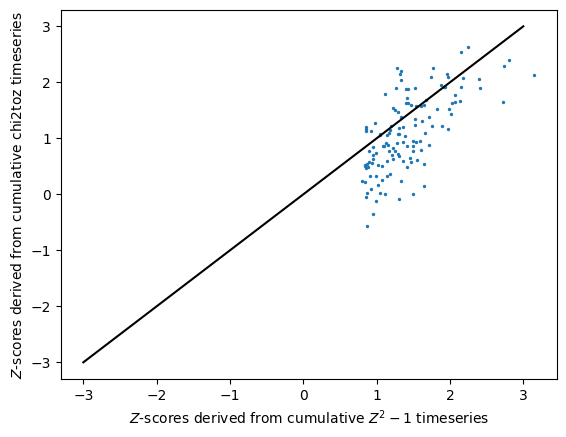

In [10]:
%matplotlib inline
plt.scatter(csm1_zscores["test"], chi2toz_zscores["test"], s=2)
plt.xlabel("$Z$-scores derived from cumulative $Z^2 - 1$ timeseries")
plt.ylabel("$Z$-scores derived from cumulative chi2toz timeseries")
plt.plot([-3,3],[-3,3], color="black")
plt.show()

In [11]:
def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([-np.log10(
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(pvals_csm1["test"])),
                  1.0/NUM_PERMUTATIONS)
      ) )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [17]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(pvals_csm1["test"]) #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals, savefilename):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals, control3_pvals, control4_pvals]]

  test_metapvals = get_iterative_metapvals(test_pvals)
  control1_metapvals = get_iterative_metapvals(control1_pvals)
  control2_metapvals = get_iterative_metapvals(control2_pvals)
  control3_metapvals = get_iterative_metapvals(control3_pvals)
  control4_metapvals = get_iterative_metapvals(control4_pvals)

  theslice = slice(min_meta-1, max_meta)

  handles = []

  rng = np.random.RandomState(1234)

  maxsimmetapval_arr = np.max(simulated_metapvals_arr[:,theslice], axis=1)
  maxtestmetapval = np.max(-np.log10(test_metapvals[theslice]))
  maxcontrol1metapval = np.max(-np.log10(control1_metapvals[theslice]))
  maxcontrol2metapval = np.max(-np.log10(control2_metapvals[theslice]))
  maxcontrol3metapval = np.max(-np.log10(control3_metapvals[theslice]))
  maxcontrol4metapval = np.max(-np.log10(control4_metapvals[theslice]))

  print("Testing for positive meta-analysis z-scores:")
  print("test pval:", np.sum(maxtestmetapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control3 pval:", np.sum(maxcontrol3metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control4 pval:", np.sum(maxcontrol4metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))

  print("Testing for negative meta-analysis z-scores:")
  print("test pval:", np.sum(maxtestmetapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control3 pval:", np.sum(maxcontrol3metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control4 pval:", np.sum(maxcontrol4metapval > maxsimmetapval_arr)/len(maxsimmetapval_arr))

  matplotlib.use('agg')
  fig = plt.figure(figsize=(15,4))
  #for simulated_metapvals in simulated_metapvals_arr:
  #  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-np.power(10,-simulated_metapvals[theslice])), color="orange", alpha=0.003)

  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-test_pvals[:max_meta]), color="blue", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(1-control1_pvals[:max_meta]), color="green", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control2_pvals[:max_meta]), color="red", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control3_pvals[:max_meta]), color="purple", s=2)
  plt.scatter(xaxis_full, scipy.stats.norm().ppf(control4_pvals[:max_meta]), color="pink", s=2)

  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-test_metapvals[theslice]), color="blue")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control1_metapvals[theslice]), color="green")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control2_metapvals[theslice]), color="red")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control3_metapvals[theslice]), color="purple")
  plt.plot(xaxis_slice, scipy.stats.norm().ppf(1-control4_metapvals[theslice]), color="pink")

  plt.plot([min(xaxis_full), max(xaxis_full)],
           [0, 0],
           color="black", linestyle="--")
  plt.plot(xaxis_full, csm1_zscores["test"][:max_meta], color="black")
  plt.ylim(-4,4)
  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("Z-score") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                      mpatches.Patch(color='green', label='Control 1 signals (before)'),
                      mpatches.Patch(color='red', label='Control 2 signals (after)'),
                      #mpatches.Patch(color='orange', label='Null distribution ('+str(metatrends_to_sim)+' simulated)'),
                      mpatches.Patch(color='black', label='Original event Z-scores')
                    ],
             loc="lower left")
  fig.savefig("analysis/metapval_"+savefilename+'.png')
  plt.close(fig)
  plt.clf()

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


csm1
csm1 ljundbox
Testing for positive meta-analysis z-scores:
test pval: 0.122
control1 pval: 0.3576
control2 pval: 0.1834
control3 pval: 0.216
control4 pval: 0.266
Testing for negative meta-analysis z-scores:
test pval: 0.878
control1 pval: 0.6424
control2 pval: 0.8166
control3 pval: 0.784
control4 pval: 0.734


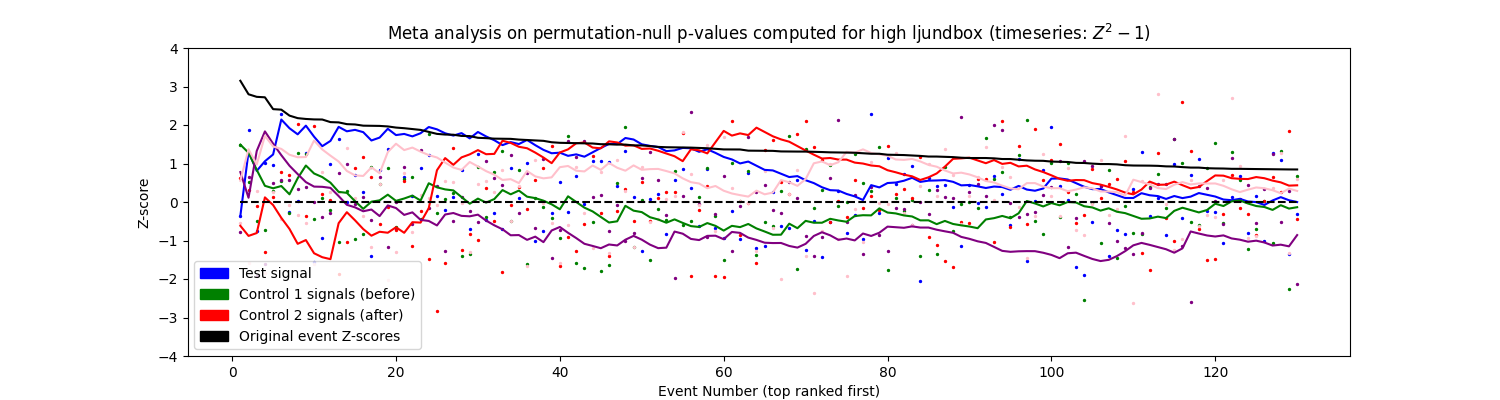

csm1 ef
Testing for positive meta-analysis z-scores:
test pval: 0.0564
control1 pval: 0.6858
control2 pval: 0.1546
control3 pval: 0.5632
control4 pval: 0.3858
Testing for negative meta-analysis z-scores:
test pval: 0.9436
control1 pval: 0.3142
control2 pval: 0.8454
control3 pval: 0.4368
control4 pval: 0.6142


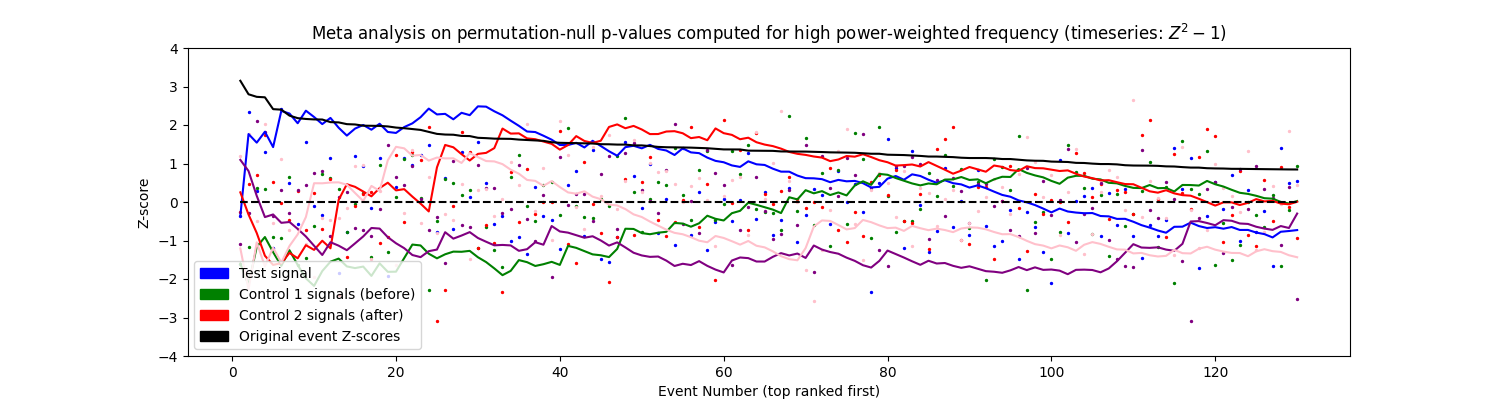

csm1 maxd
Testing for positive meta-analysis z-scores:
test pval: 0.1756
control1 pval: 0.4162
control2 pval: 0.1508
control3 pval: 0.358
control4 pval: 0.3404
Testing for negative meta-analysis z-scores:
test pval: 0.8244
control1 pval: 0.5838
control2 pval: 0.8492
control3 pval: 0.642
control4 pval: 0.6596


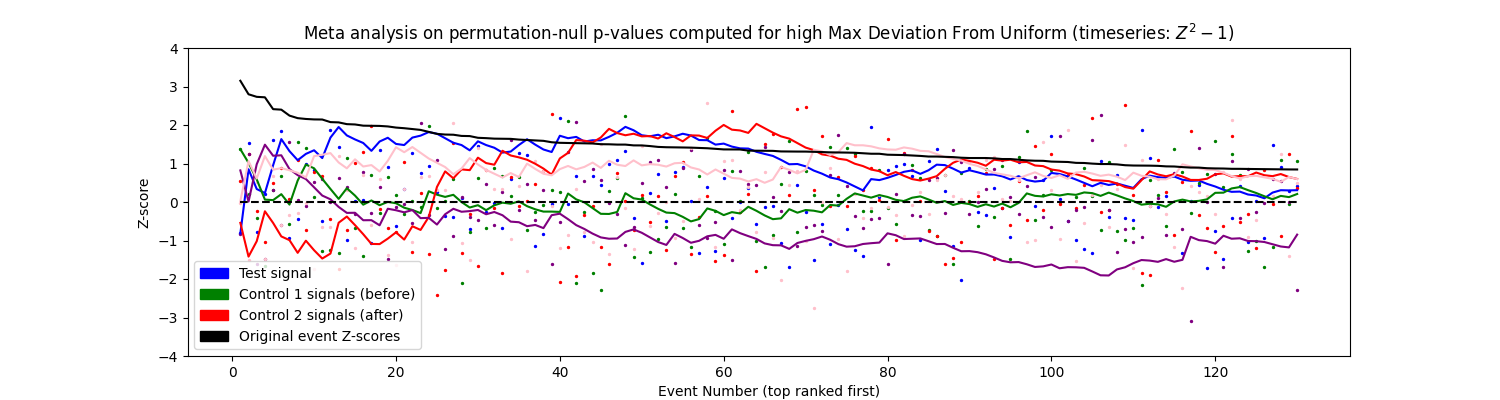

csm1 p00625
Testing for positive meta-analysis z-scores:
test pval: 0.189
control1 pval: 0.9982
control2 pval: 0.5386
control3 pval: 0.1364
control4 pval: 0.7936
Testing for negative meta-analysis z-scores:
test pval: 0.811
control1 pval: 0.0018
control2 pval: 0.4614
control3 pval: 0.8636
control4 pval: 0.2064


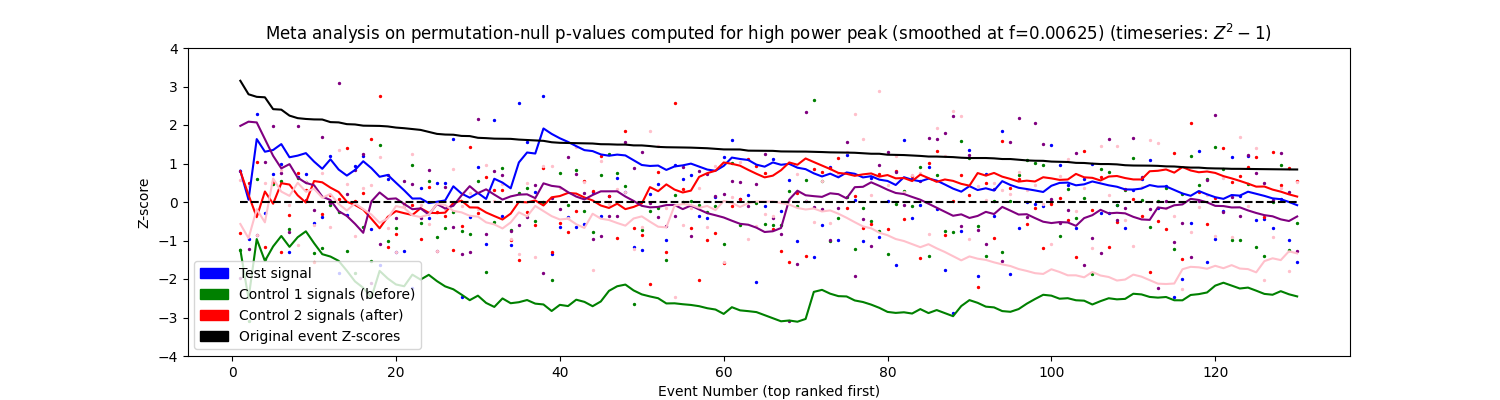

csm1 p01
Testing for positive meta-analysis z-scores:
test pval: 0.0272
control1 pval: 0.888
control2 pval: 0.6288
control3 pval: 0.3082
control4 pval: 0.6582
Testing for negative meta-analysis z-scores:
test pval: 0.9728
control1 pval: 0.112
control2 pval: 0.3712
control3 pval: 0.6918
control4 pval: 0.3418


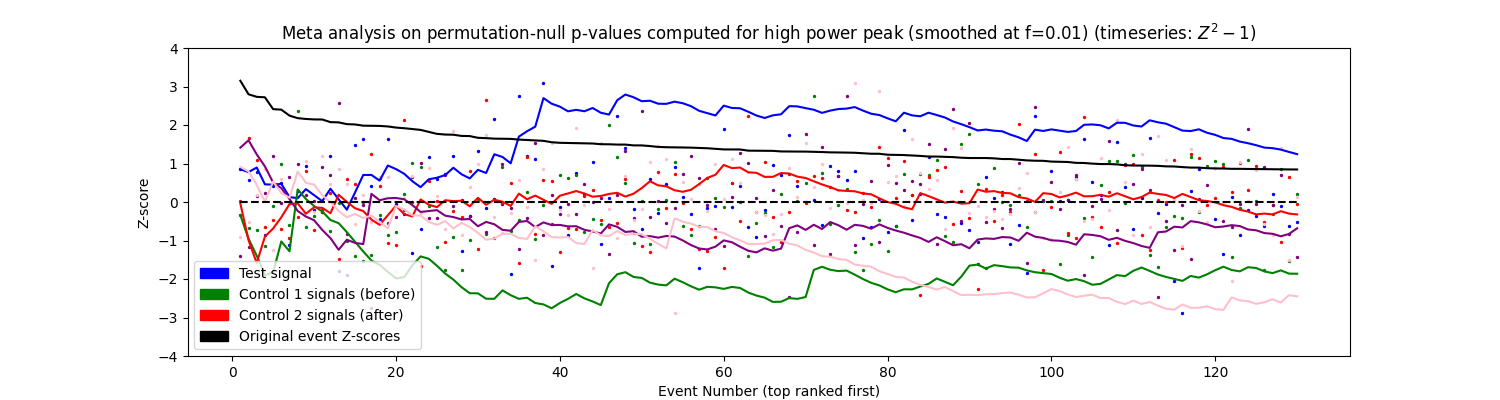

csm1 p0125
Testing for positive meta-analysis z-scores:
test pval: 0.002
control1 pval: 0.9306
control2 pval: 0.4648
control3 pval: 0.3972
control4 pval: 0.5778
Testing for negative meta-analysis z-scores:
test pval: 0.998
control1 pval: 0.0694
control2 pval: 0.5352
control3 pval: 0.6028
control4 pval: 0.4222


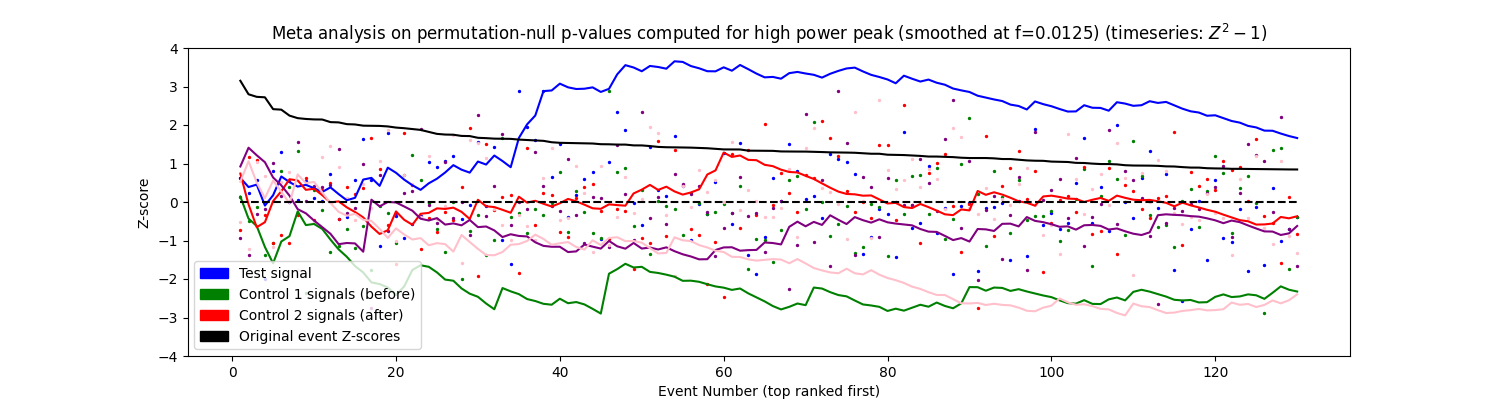

csm1 p015
Testing for positive meta-analysis z-scores:
test pval: 0.1028
control1 pval: 0.9854
control2 pval: 0.281
control3 pval: 0.484
control4 pval: 0.358
Testing for negative meta-analysis z-scores:
test pval: 0.8972
control1 pval: 0.0146
control2 pval: 0.719
control3 pval: 0.516
control4 pval: 0.642


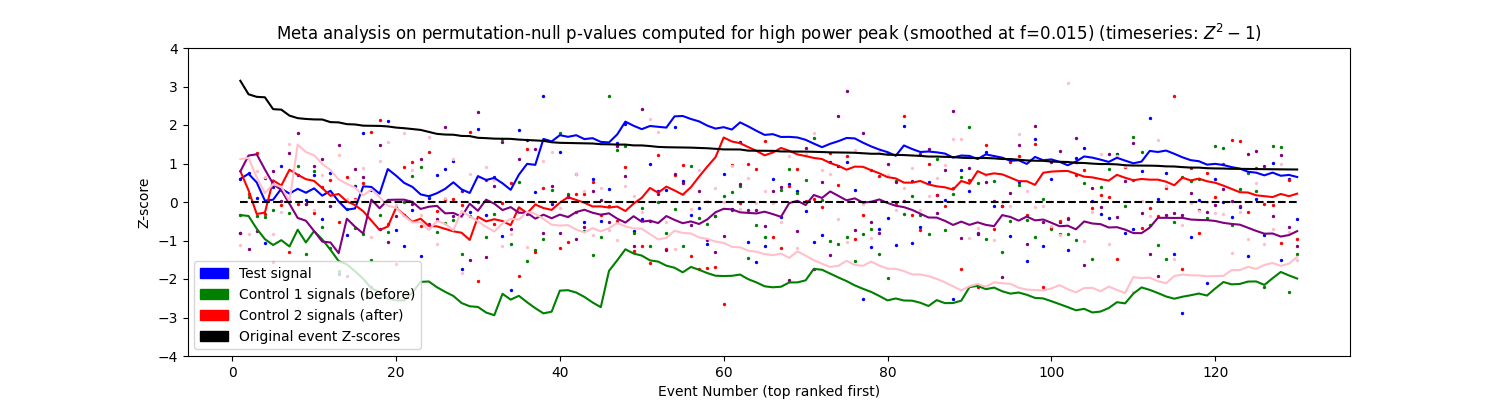

csm1 p02
Testing for positive meta-analysis z-scores:
test pval: 0.038
control1 pval: 0.9496
control2 pval: 0.2598
control3 pval: 0.5956
control4 pval: 0.06
Testing for negative meta-analysis z-scores:
test pval: 0.962
control1 pval: 0.0504
control2 pval: 0.7402
control3 pval: 0.4044
control4 pval: 0.94


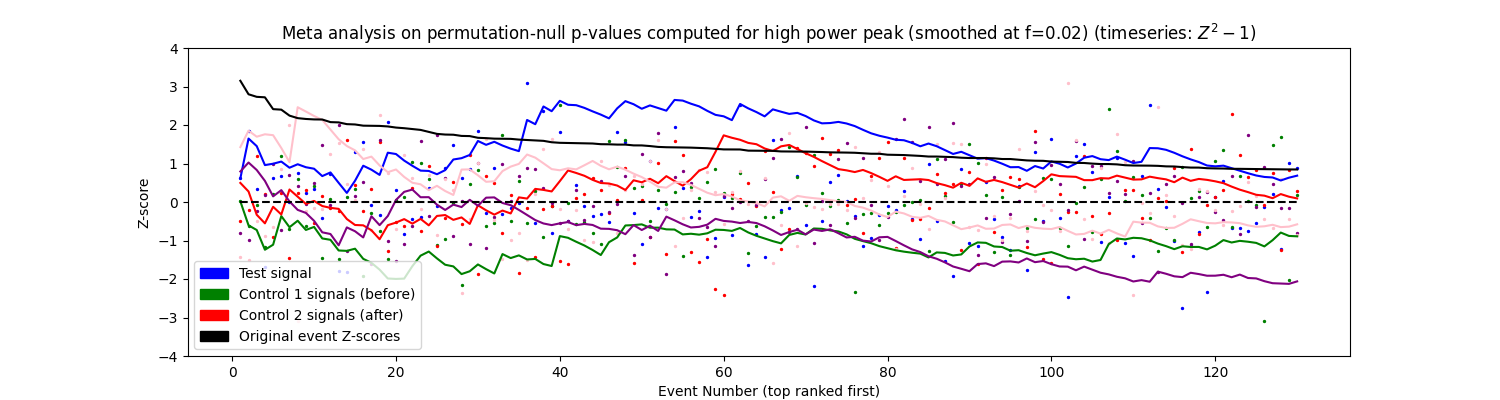

csm1 p025
Testing for positive meta-analysis z-scores:
test pval: 0.0228
control1 pval: 0.7642
control2 pval: 0.2932
control3 pval: 0.868
control4 pval: 0.1008
Testing for negative meta-analysis z-scores:
test pval: 0.9772
control1 pval: 0.2358
control2 pval: 0.7068
control3 pval: 0.132
control4 pval: 0.8992


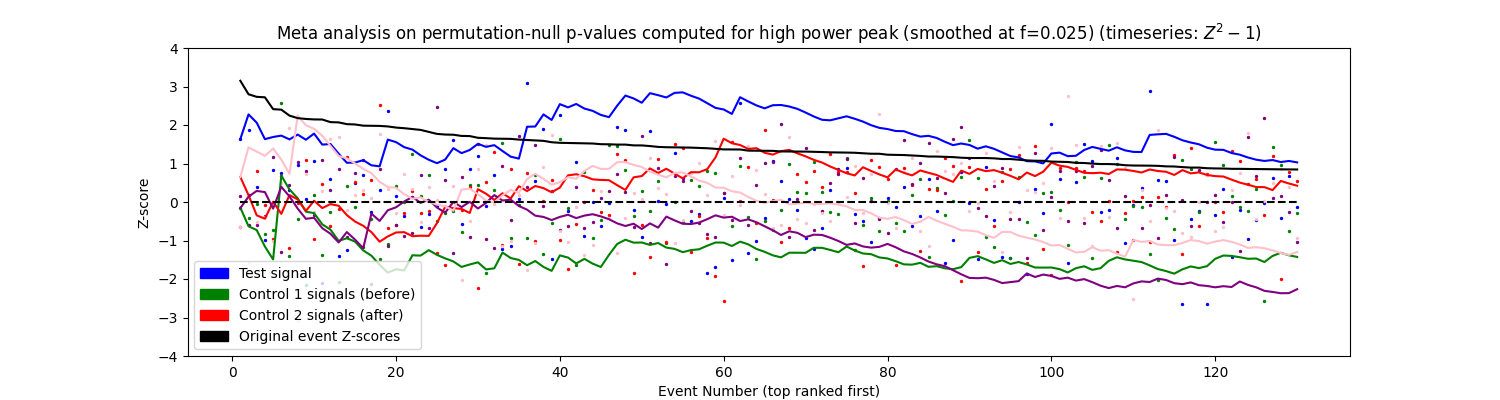

csm1 p05
Testing for positive meta-analysis z-scores:
test pval: 0.086
control1 pval: 0.474
control2 pval: 0.4798
control3 pval: 0.48
control4 pval: 0.4826
Testing for negative meta-analysis z-scores:
test pval: 0.914
control1 pval: 0.526
control2 pval: 0.5202
control3 pval: 0.52
control4 pval: 0.5174


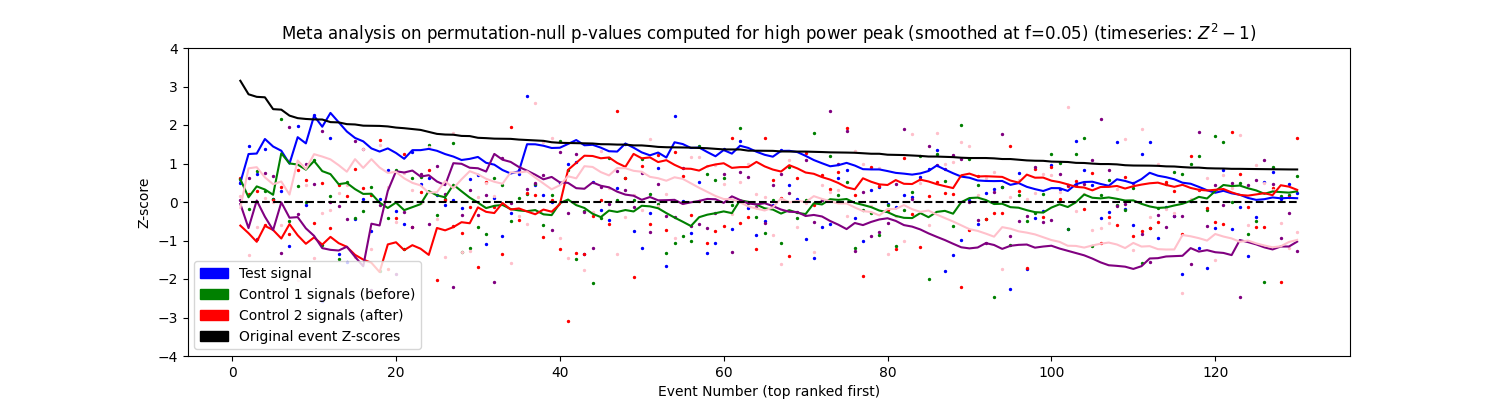

chi2toz
chi2toz ljundbox
Testing for positive meta-analysis z-scores:
test pval: 0.3198
control1 pval: 0.0154
control2 pval: 0.5586
control3 pval: 0.9304
control4 pval: 0.066
Testing for negative meta-analysis z-scores:
test pval: 0.6802
control1 pval: 0.9846
control2 pval: 0.4414
control3 pval: 0.0696
control4 pval: 0.934


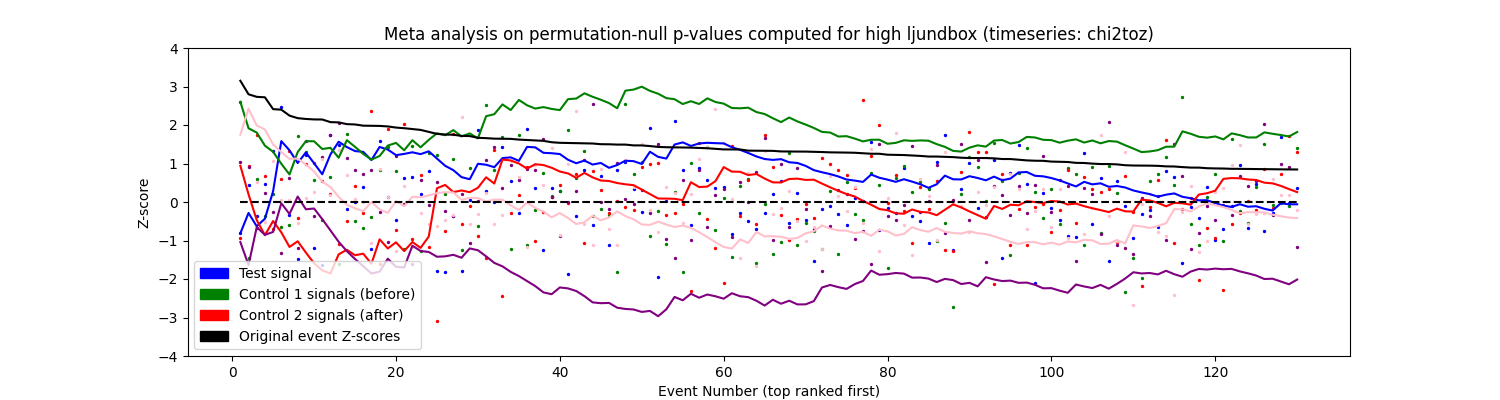

chi2toz ef
Testing for positive meta-analysis z-scores:
test pval: 0.1114
control1 pval: 0.7456
control2 pval: 0.0826
control3 pval: 0.9788
control4 pval: 0.9804
Testing for negative meta-analysis z-scores:
test pval: 0.8886
control1 pval: 0.2544
control2 pval: 0.9174
control3 pval: 0.0212
control4 pval: 0.0196


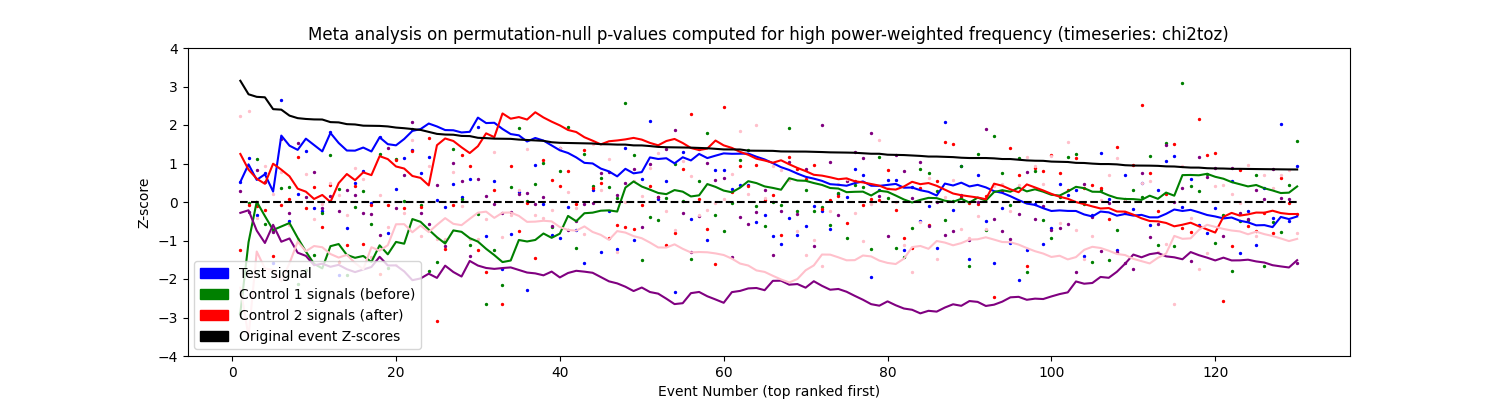

chi2toz maxd
Testing for positive meta-analysis z-scores:
test pval: 0.1508
control1 pval: 0.0248
control2 pval: 0.4356
control3 pval: 0.9802
control4 pval: 0.17
Testing for negative meta-analysis z-scores:
test pval: 0.8492
control1 pval: 0.9752
control2 pval: 0.5644
control3 pval: 0.0198
control4 pval: 0.83


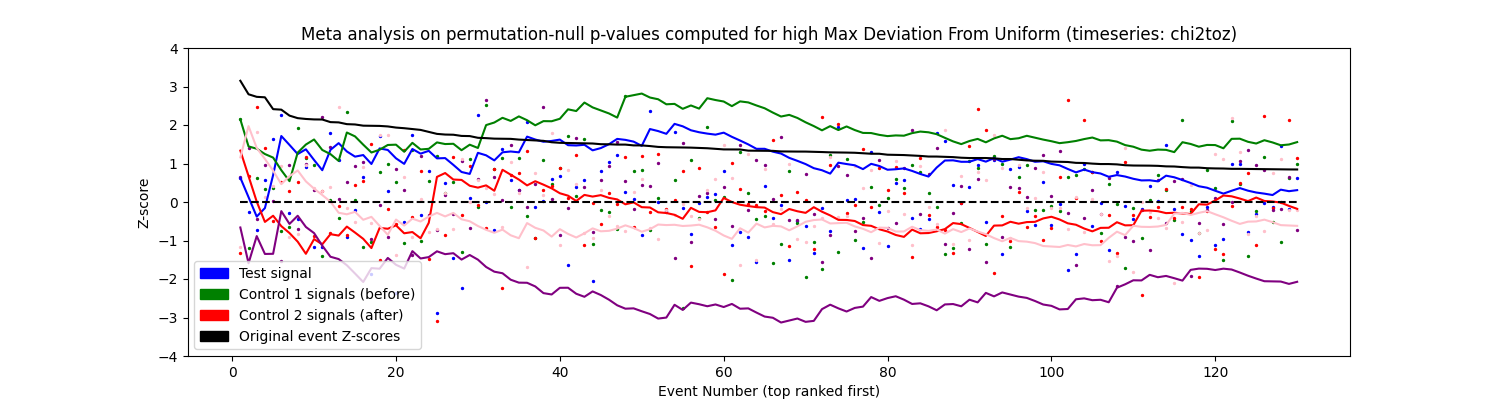

chi2toz p00625
Testing for positive meta-analysis z-scores:
test pval: 0.7276
control1 pval: 0.9672
control2 pval: 0.617
control3 pval: 0.2546
control4 pval: 0.1204
Testing for negative meta-analysis z-scores:
test pval: 0.2724
control1 pval: 0.0328
control2 pval: 0.383
control3 pval: 0.7454
control4 pval: 0.8796


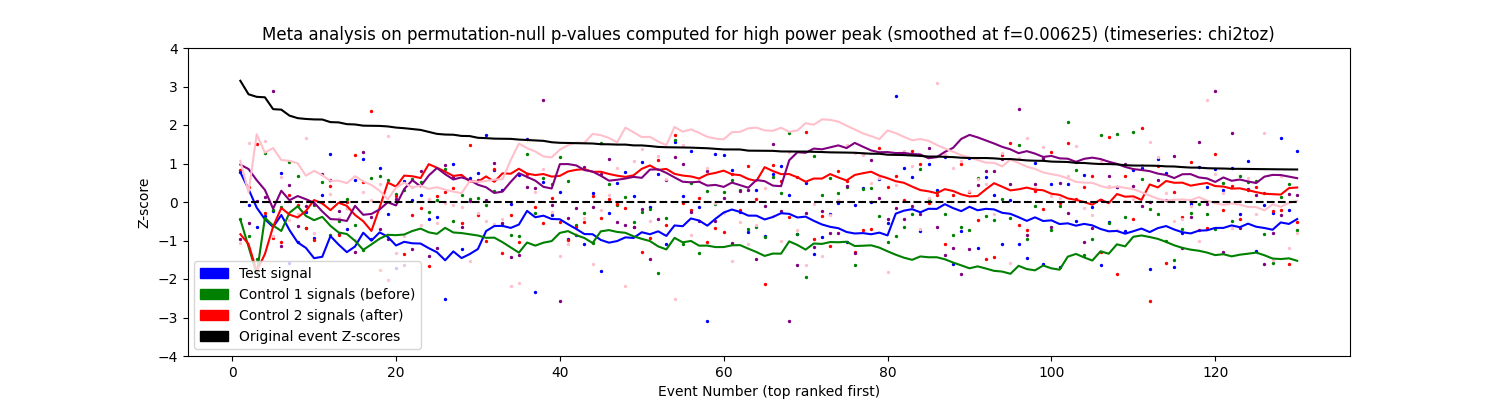

chi2toz p01
Testing for positive meta-analysis z-scores:
test pval: 0.5314
control1 pval: 0.8458
control2 pval: 0.6898
control3 pval: 0.5608
control4 pval: 0.0944
Testing for negative meta-analysis z-scores:
test pval: 0.4686
control1 pval: 0.1542
control2 pval: 0.3102
control3 pval: 0.4392
control4 pval: 0.9056


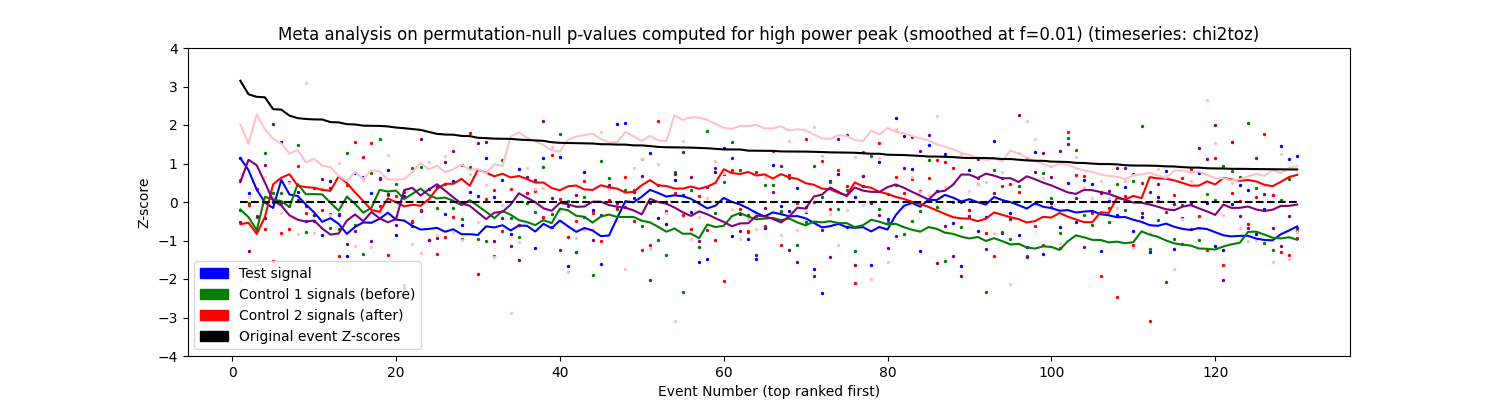

chi2toz p0125
Testing for positive meta-analysis z-scores:
test pval: 0.34
control1 pval: 0.5674
control2 pval: 0.4828
control3 pval: 0.2356
control4 pval: 0.036
Testing for negative meta-analysis z-scores:
test pval: 0.66
control1 pval: 0.4326
control2 pval: 0.5172
control3 pval: 0.7644
control4 pval: 0.964


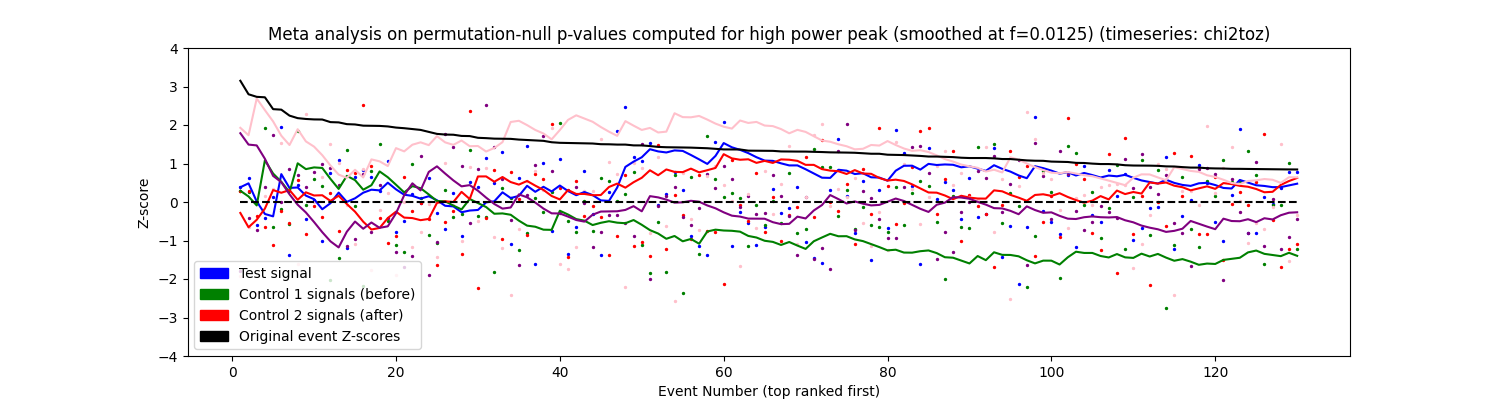

chi2toz p015
Testing for positive meta-analysis z-scores:
test pval: 0.6364
control1 pval: 0.6314
control2 pval: 0.5806
control3 pval: 0.2088
control4 pval: 0.0564
Testing for negative meta-analysis z-scores:
test pval: 0.3636
control1 pval: 0.3686
control2 pval: 0.4194
control3 pval: 0.7912
control4 pval: 0.9436


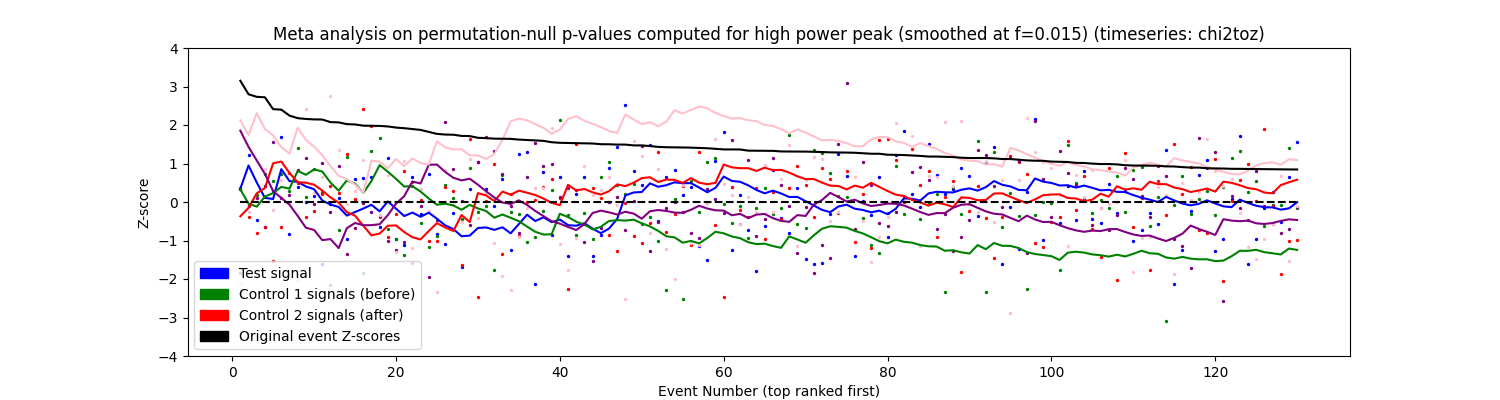

chi2toz p02
Testing for positive meta-analysis z-scores:
test pval: 0.675
control1 pval: 0.4616
control2 pval: 0.8338
control3 pval: 0.565
control4 pval: 0.2666
Testing for negative meta-analysis z-scores:
test pval: 0.325
control1 pval: 0.5384
control2 pval: 0.1662
control3 pval: 0.435
control4 pval: 0.7334


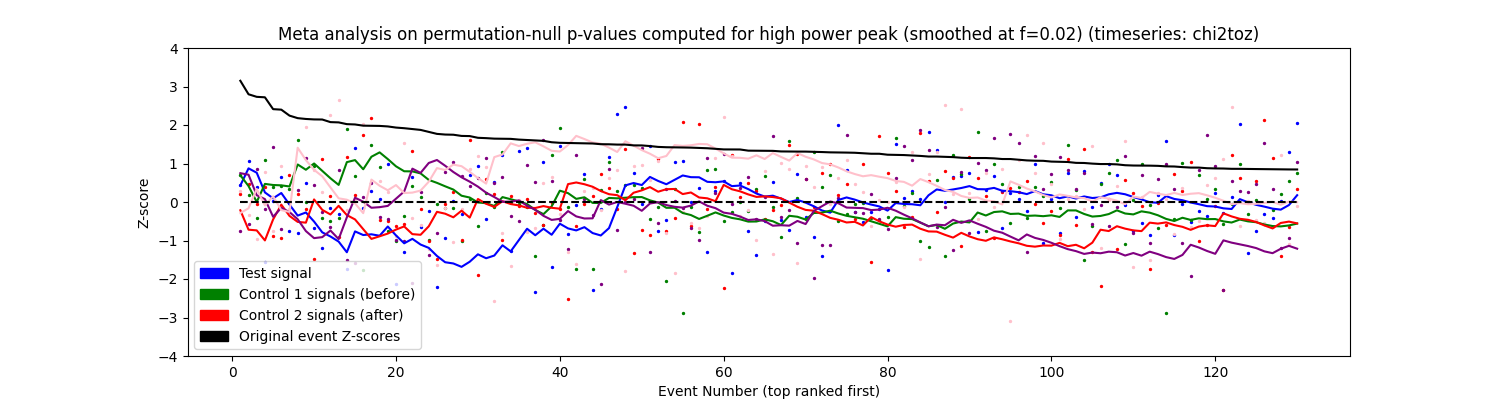

chi2toz p025
Testing for positive meta-analysis z-scores:
test pval: 0.5532
control1 pval: 0.4552
control2 pval: 0.5752
control3 pval: 0.6242
control4 pval: 0.403
Testing for negative meta-analysis z-scores:
test pval: 0.4468
control1 pval: 0.5448
control2 pval: 0.4248
control3 pval: 0.3758
control4 pval: 0.597


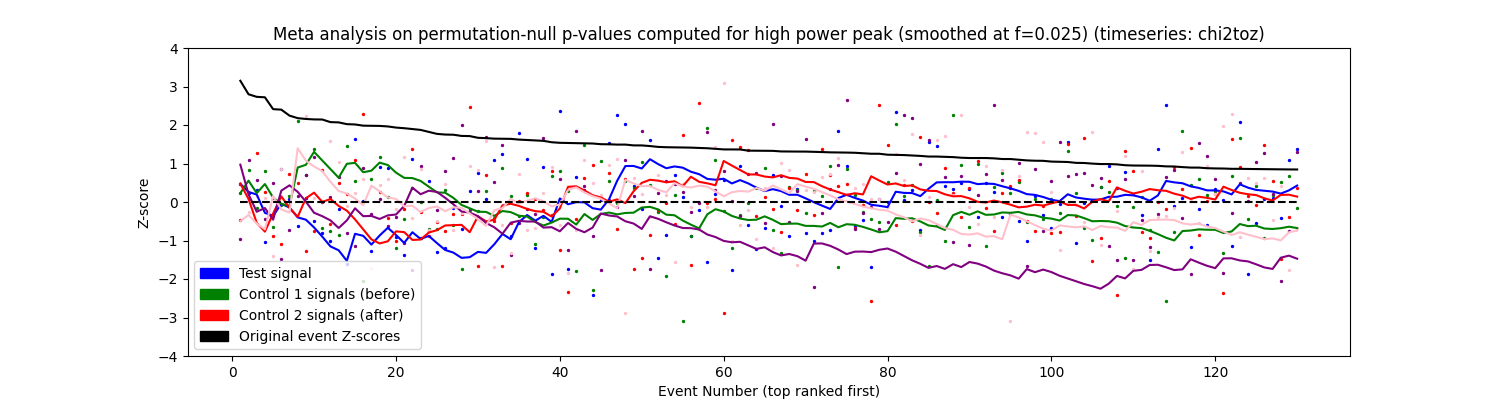

chi2toz p05
Testing for positive meta-analysis z-scores:
test pval: 0.9776
control1 pval: 0.4938
control2 pval: 0.9302
control3 pval: 0.3538
control4 pval: 0.8272
Testing for negative meta-analysis z-scores:
test pval: 0.0224
control1 pval: 0.5062
control2 pval: 0.0698
control3 pval: 0.6462
control4 pval: 0.1728


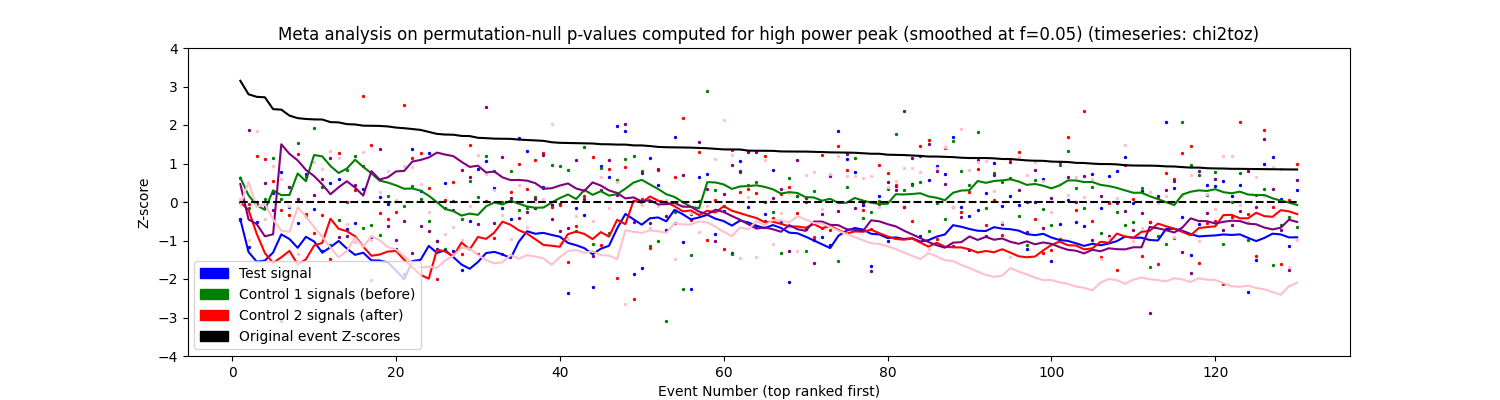

In [18]:
for signalname, signaldisplayname, pvals in [('csm1', '$Z^2 - 1$', pvals_csm1),
                                             ('chi2toz', 'chi2toz', pvals_chi2toz)]:
  print(signalname)
  for metricname, metricdisplayname in [('ljundbox', 'ljundbox'),
                                        ('ef', 'power-weighted frequency'),
                                        ('maxd', 'Max Deviation From Uniform'),
                                        ('p00625', 'power peak (smoothed at f=0.00625)'),
                                        ('p01', 'power peak (smoothed at f=0.01)'),
                                        ('p0125', 'power peak (smoothed at f=0.0125)'),
                                        ('p015', 'power peak (smoothed at f=0.015)'),
                                        ('p02', 'power peak (smoothed at f=0.02)'),
                                        ('p025', 'power peak (smoothed at f=0.025)'),
                                        ('p05', 'power peak (smoothed at f=0.05)')]:
    print(signalname,metricname)
    make_meta_trend_plot(
      "Meta analysis on permutation-null p-values computed for high "
        +metricdisplayname+" (timeseries: "+signaldisplayname+")",
      test_pvals=np.array([x["pval_"+metricname] for x in pvals["test"]]),
      control1_pvals=np.array([x["pval_"+metricname] for x in pvals["control1"]]),
      control2_pvals=np.array([x["pval_"+metricname] for x in pvals["control2"]]),
      control3_pvals=np.array([x["pval_"+metricname] for x in pvals["control3"]]),
      control4_pvals=np.array([x["pval_"+metricname] for x in pvals["control4"]]),
      savefilename=signalname+"_"+metricname)
    display(Image("analysis/metapval_"+signalname+"_"+metricname+".png"))

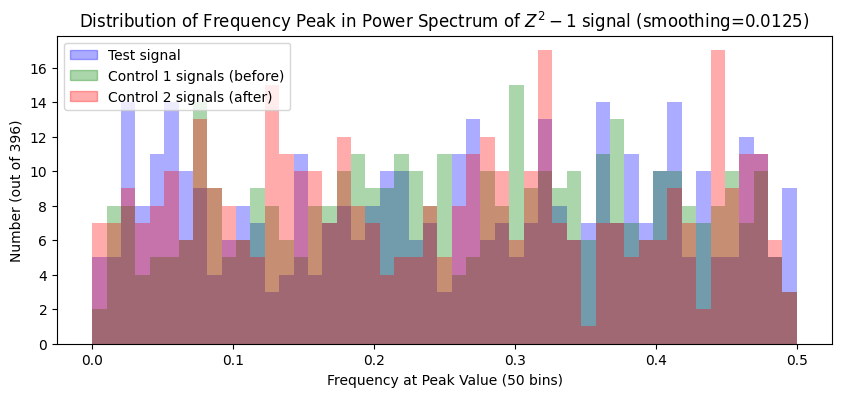

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,4))
_, bins, _ = plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["test"]],
                      bins=np.linspace(0,0.5,50), color="blue", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control1"]],
         bins=np.linspace(0,0.5,50), color="green", alpha=0.33)
plt.hist([x["peak_freqs"]['0.0125'] for x in pvals_csm1["control2"]],
         bins=np.linspace(0,0.5,50), color="red", alpha=0.33)
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal', alpha=0.33),
                    mpatches.Patch(color='green', label='Control 1 signals (before)', alpha=0.33),
                    mpatches.Patch(color='red', label='Control 2 signals (after)', alpha=0.33)],
             loc="upper left")
plt.title("Distribution of Frequency Peak in Power Spectrum of $Z^2 - 1$ signal (smoothing=0.0125)")
plt.xlabel("Frequency at Peak Value (50 bins)")
plt.ylabel("Number (out of "+str(len(pvals_csm1["test"]))+")")
plt.show()